<a href="https://colab.research.google.com/github/smartcs98/modern-cpp-features/blob/master/HackathonProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cleaning, Preprocessing and generating synthetic data

In [1]:
# @title
# --- 1. Upload the file interactively ---
from google.colab import files
uploaded = files.upload()

# This will upload your file.
# For example if you upload "Hackathon Raw data.xlsx",
# Colab will save it in the current working directory.

import pandas as pd
import numpy as np

# --- 2. Automatically detect the uploaded filename ---
filename = list(uploaded.keys())[0]
print("Using file:", filename)

# --- 3. Load dataset ---
df = pd.read_excel(filename, sheet_name="Renewal Raw ")

# --- 4. Clean column names ---
df.columns = [c.strip() for c in df.columns]

df = df.rename(columns={
    "Accounts": "account_id",
    "Stage": "stage",
    "Fiscal Period": "fiscal_period",
    "Sales Entity": "sales_entity",
    "Consumption Phase": "consumption_phase",
    "Renewal Risk(CSM)": "renewal_risk_csm",
    "Type": "type",
    "CSM Account Details.Customer Type": "customer_type",
    "SaaS SLA": "saas_sla",
    "SW SLA": "sw_sla",
    "NPS": "nps"
})

# --- 5. Create churn label ---
df["churn"] = (df["stage"] == "Closed / Lost").astype(int)

# --- 6. Handle Renewal Risk (CSM) ---
df["renewal_risk_csm"] = df["renewal_risk_csm"].fillna("Unknown")
risk_map = {"Low": 0, "Medium": 1, "High": 2, "Unknown": -1}
df["risk_ordinal"] = df["renewal_risk_csm"].map(risk_map)

risk_dummies = pd.get_dummies(df["renewal_risk_csm"], prefix="risk")
for col in ["risk_Low", "risk_Medium", "risk_High", "risk_Unknown"]:
    if col not in risk_dummies.columns:
        risk_dummies[col] = 0

df = pd.concat([df, risk_dummies], axis=1)

# --- 7. Missing categorical → Unknown ---
df["consumption_phase"] = df["consumption_phase"].fillna("Unknown")
df["customer_type"] = df["customer_type"].fillna("Unknown")

# --- 8. Missingness flags for numeric features ---
for col in ["saas_sla", "sw_sla", "nps"]:
    df[f"has_{col}"] = df[col].notna().astype(int)

# --- 9. Group-wise median imputation ---
group_col = "customer_type"
for col in ["saas_sla", "sw_sla", "nps"]:
    med = df.groupby(group_col)[col].transform("median")
    df[col] = df[col].fillna(med)
    df[col] = df[col].fillna(df[col].median())

# --- 10. Parse fiscal period Q1-2026 ---
period = df["fiscal_period"].str.extract(r"Q(\d+)-(\d+)")
df["fiscal_quarter"] = period[0].astype(int)
df["fiscal_year"] = period[1].astype(int)

# --- 11. Save cleaned dataset ---
df.to_csv("renewal_clean.csv", index=False)

print("Cleaning completed. Saved as renewal_clean.csv")

df.head()


Saving Hackathon Raw data.xlsx to Hackathon Raw data.xlsx
Using file: Hackathon Raw data.xlsx
Cleaning completed. Saved as renewal_clean.csv


,account_id,stage,fiscal_period,sales_entity,consumption_phase,renewal_risk_csm,type,customer_type,saas_sla,sw_sla,...,risk_ordinal,risk_High,risk_Low,risk_Medium,risk_Unknown,has_saas_sla,has_sw_sla,has_nps,fiscal_quarter,fiscal_year
0,0014000001YfESNAA3,Closed / Lost,Q2-2026,EMEA,Onboard,High,SaaS,SaaS only,28.57,0.0,...,2,True,False,False,False,1,0,1,2,2026
1,001Do00000FiOERIA3,Closed / Lost,Q2-2026,EMEA,Onboard,Medium,SaaS,SaaS only,100.00,0.0,...,1,False,False,True,False,1,0,0,2,2026
2,0014000000dLua7AAC,Closed / Lost,Q1-2026,EMEA,Unknown,Unknown,SaaS,SW only,50.00,96.0,...,-1,False,False,False,True,0,1,0,1,2026
3,001Vm00000aNYPFIA4,Closed / Lost,Q2-2026,EMEA,Expand,Unknown,SaaS,SaaS only,100.00,0.0,...,-1,False,False,False,True,1,0,0,2,2026
4,0014000000d1xTWAAY,Closed/Won,Q1-2026,EMEA,Onboard,Low,SaaS,SaaS and SW,100.00,94.0,...,0,False,True,False,False,1,0,0,1,2026


In [2]:
# @title
df = pd.read_csv("renewal_clean.csv")
df.head()


,account_id,stage,fiscal_period,sales_entity,consumption_phase,renewal_risk_csm,type,customer_type,saas_sla,sw_sla,...,risk_ordinal,risk_High,risk_Low,risk_Medium,risk_Unknown,has_saas_sla,has_sw_sla,has_nps,fiscal_quarter,fiscal_year
0,0014000001YfESNAA3,Closed / Lost,Q2-2026,EMEA,Onboard,High,SaaS,SaaS only,28.57,0.0,...,2,True,False,False,False,1,0,1,2,2026
1,001Do00000FiOERIA3,Closed / Lost,Q2-2026,EMEA,Onboard,Medium,SaaS,SaaS only,100.00,0.0,...,1,False,False,True,False,1,0,0,2,2026
2,0014000000dLua7AAC,Closed / Lost,Q1-2026,EMEA,Unknown,Unknown,SaaS,SW only,50.00,96.0,...,-1,False,False,False,True,0,1,0,1,2026
3,001Vm00000aNYPFIA4,Closed / Lost,Q2-2026,EMEA,Expand,Unknown,SaaS,SaaS only,100.00,0.0,...,-1,False,False,False,True,1,0,0,2,2026
4,0014000000d1xTWAAY,Closed/Won,Q1-2026,EMEA,Onboard,Low,SaaS,SaaS and SW,100.00,94.0,...,0,False,True,False,False,1,0,0,1,2026


In [3]:
# @title
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df,
                                     test_size=0.2,
                                     random_state=42,
                                     stratify=df['churn'])


In [5]:
# @title
from imblearn.over_sampling import SMOTE
import pandas as pd

# start from your cleaned train_df
# train_df has 'churn' and all processed columns from renewal_clean.csv

# 1. Drop columns we don't want as features
cols_to_drop = [
    "churn",           # target
    "account_id",      # identifier
    "stage",           # leaks the label (Closed/Won vs Closed/Lost)
    "fiscal_period",   # raw string, we use year/quarter instead
    "renewal_risk_csm" # we already have risk_ordinal + risk_* dummies
]

feature_df = train_df.drop(columns=cols_to_drop, errors="ignore")

# 2. One-hot encode remaining categorical columns
# (objects + any category dtype)
X = pd.get_dummies(feature_df, drop_first=False)

# 3. Target vector
y = train_df["churn"]

print("X shape before SMOTE:", X.shape)
print("Churn distribution before SMOTE:\n", y.value_counts())

# 4. Apply SMOTE
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X, y)

print("X shape after SMOTE:", X_sm.shape)
print("Churn distribution after SMOTE:\n", pd.Series(y_sm).value_counts())

# 5. (Optional) rebuild a DataFrame for convenience
X_sm = pd.DataFrame(X_sm, columns=X.columns)
train_sm = X_sm.copy()
train_sm["churn"] = y_sm


X shape before SMOTE: (358, 28)
Churn distribution before SMOTE:
 churn
0    318
1     40
Name: count, dtype: int64
X shape after SMOTE: (636, 28)
Churn distribution after SMOTE:
 churn
0    318
1    318
Name: count, dtype: int64


In [6]:
# @title
train_sm["churn"].value_counts()


,count
churn,
0,318
1,318


In [7]:
# @title
print(train_sm["churn"].value_counts())


churn
0    318
1    318
Name: count, dtype: int64


In [8]:
# @title
!pip install ctgan


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.5 MB/s eta 0:00:00


In [10]:
# @title
!pip install sdv


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.6/196.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.3/198.3 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 7.8 MB/s eta 0:00:00


In [11]:
# @title
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata


In [12]:
# @title
import pandas as pd

df = pd.read_csv("renewal_clean.csv")

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)
metadata.columns


{'account_id': {'sdtype': 'id'},
 'stage': {'sdtype': 'categorical'},
 'fiscal_period': {'sdtype': 'categorical'},
 'sales_entity': {'sdtype': 'categorical'},
 'consumption_phase': {'sdtype': 'categorical'},
 'renewal_risk_csm': {'sdtype': 'categorical'},
 'type': {'sdtype': 'categorical'},
 'customer_type': {'sdtype': 'categorical'},
 'saas_sla': {'sdtype': 'numerical'},
 'sw_sla': {'sdtype': 'numerical'},
 'nps': {'sdtype': 'numerical'},
 'churn': {'sdtype': 'categorical'},
 'risk_ordinal': {'sdtype': 'numerical'},
 'risk_High': {'sdtype': 'categorical'},
 'risk_Low': {'sdtype': 'categorical'},
 'risk_Medium': {'sdtype': 'categorical'},
 'risk_Unknown': {'sdtype': 'categorical'},
 'has_saas_sla': {'sdtype': 'categorical'},
 'has_sw_sla': {'sdtype': 'categorical'},
 'has_nps': {'sdtype': 'categorical'},
 'fiscal_quarter': {'sdtype': 'categorical'},
 'fiscal_year': {'sdtype': 'categorical'}}

In [13]:
# @title
synth = CTGANSynthesizer(metadata, epochs=300)


/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:168: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.12/dist-packages/sdv/single_table/base.py:134: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [14]:
# @title
synth.fit(df)


/usr/local/lib/python3.12/dist-packages/ctgan/synthesizers/_utils.py:16: FutureWarning: `cuda` parameter is deprecated and will be removed in a future release. Please use `enable_gpu` instead.
  warnings.warn(


In [15]:
# @title
synthetic_df = synth.sample(10000)
synthetic_df.to_csv("synthetic_10000.csv", index=False)

synthetic_df.head()


,account_id,stage,fiscal_period,sales_entity,consumption_phase,renewal_risk_csm,type,customer_type,saas_sla,sw_sla,...,risk_ordinal,risk_High,risk_Low,risk_Medium,risk_Unknown,has_saas_sla,has_sw_sla,has_nps,fiscal_quarter,fiscal_year
0,sdv-id-ZyeEqV,Closed/Won,Q1-2026,Americas,Onboard,Medium,SaaS,SaaS only,94.37,90.0,...,0,False,False,True,False,0,1,1,1,2026
1,sdv-id-UtKJYE,Closed/Won,Q2-2026,EMEA,Onboard,Medium,SW,SaaS only,43.02,100.0,...,1,False,False,False,False,1,1,0,2,2026
2,sdv-id-wbsbhy,Closed/Won,Q1-2026,Americas,Adopt,Unknown,SaaS,SW only,93.19,21.0,...,1,False,False,True,False,1,1,1,2,2026
3,sdv-id-zjjnpI,Closed/Won,Q1-2026,INDIA,Activate,Medium,SaaS,SW only,90.63,100.0,...,0,False,False,True,False,0,0,0,1,2026
4,sdv-id-ZuJUDx,Closed/Won,Q2-2026,APAC,Expand,Low,SaaS,SW only,45.28,100.0,...,0,False,False,False,False,1,0,1,2,2026


Train the Churn Model

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load cleaned real dataset
df_real = pd.read_csv("renewal_clean.csv")

# Load synthetic dataset
df_synth = pd.read_csv("synthetic_10000.csv")

print("Real:", df_real.shape, "Synthetic:", df_synth.shape)

# 1. Split REAL into train/test (hold out some real data for honest evaluation)
real_train, real_test = train_test_split(
    df_real,
    test_size=0.2,
    stratify=df_real["churn"],
    random_state=42
)

print("Real train:", real_train.shape, "Real test:", real_test.shape)

# 2. Combine REAL TRAIN + SYNTHETIC into a big training set
train_full = pd.concat([real_train, df_synth], ignore_index=True)
print("Combined train (real + synthetic):", train_full.shape)


Real: (448, 22) Synthetic: (10000, 22)
Real train: (358, 22) Real test: (90, 22)
Combined train (real + synthetic): (10358, 22)


In [17]:
import numpy as np

drop_cols = [
    "account_id",
    "stage",
    "fiscal_period",
    "renewal_risk_csm"
]

target_col = "churn"

def prepare_features(df: pd.DataFrame):
    """
    Takes a dataframe with original columns and returns:
      X: numeric feature matrix
      y: target (if present), else None
    """
    df = df.copy()

    # Separate target if exists
    y = df[target_col] if target_col in df.columns else None

    # Drop target and non-feature columns
    X = df.drop(columns=drop_cols + [target_col], errors="ignore")

    # One-hot encode any remaining categoricals
    X = pd.get_dummies(X, drop_first=False)

    return X, y


In [18]:
X_train_full, y_train_full = prepare_features(train_full)
X_test, y_test = prepare_features(real_test)

print("X_train_full:", X_train_full.shape)
print("X_test:", X_test.shape)


X_train_full: (10358, 28)
X_test: (90, 28)


In [19]:
# Align columns: add missing columns with 0s
missing_in_test = set(X_train_full.columns) - set(X_test.columns)
missing_in_train = set(X_test.columns) - set(X_train_full.columns)

for col in missing_in_test:
    X_test[col] = 0

for col in missing_in_train:
    X_train_full[col] = 0

# Ensure same column order
X_test = X_test[X_train_full.columns]

print("After alignment:")
print("X_train_full:", X_train_full.shape)
print("X_test:", X_test.shape)


After alignment:
X_train_full: (10358, 28)
X_test: (90, 28)


In [20]:
!pip install lightgbm


In [21]:
import lightgbm as lgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Compute class weight: more weight to churn if imbalanced
pos_weight = (y_train_full.value_counts()[0] / y_train_full.value_counts()[1])
print("Scale_pos_weight (approx):", pos_weight)

train_dataset = lgb.Dataset(X_train_full, label=y_train_full)

params = {
    "objective": "binary",
    "metric": ["binary_logloss", "auc"],
    "learning_rate": 0.05,
    "num_leaves": 31,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": -1,
    "scale_pos_weight": pos_weight  # handle class imbalance
}

lgbm_model = lgb.train(
    params,
    train_dataset,
    num_boost_round=500
)


Scale_pos_weight (approx): 5.580686149936468


In [22]:
# Predict probabilities and classes on REAL test
y_proba = lgbm_model.predict(X_test)
y_pred = (y_proba >= 0.5).astype(int)

print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification report:\n")
print(classification_report(y_test, y_pred, digits=3))

print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))


ROC AUC: 0.7643749999999999

Classification report:

              precision    recall  f1-score   support

           0      0.919     0.850     0.883        80
           1      0.250     0.400     0.308        10

    accuracy                          0.800        90
   macro avg      0.584     0.625     0.595        90
weighted avg      0.845     0.800     0.819        90


Confusion matrix:
 [[68 12]
 [ 6  4]]


In [26]:
!pip install shap


In [27]:
import shap

explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X_test)


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


In [29]:
shap_churn = shap_values[1]  # SHAP values pushing towards churn


In [30]:
FEATURE_LABELS = {
    "saas_sla": "SaaS SLA performance",
    "sw_sla": "SW SLA performance",
    "nps": "NPS score",
    "risk_ordinal": "CSM renewal risk",
    "has_nps": "NPS availability",
    "has_saas_sla": "SaaS SLA telemetry availability",
    "has_sw_sla": "SW SLA telemetry availability",
    "consumption_phase_Onboard": "Consumption phase = Onboard",
    "consumption_phase_Adopt": "Consumption phase = Adopt",
    "consumption_phase_Expand": "Consumption phase = Expand",
    "consumption_phase_Activate": "Consumption phase = Activate",
    "consumption_phase_Unknown": "Consumption phase = Unknown",
    "sales_entity_APAC": "Region = APAC",
    "sales_entity_EMEA": "Region = EMEA",
    "sales_entity_Americas": "Region = Americas",
    "sales_entity_INDIA": "Region = India",
    "customer_type_SaaS only": "Customer type = SaaS only",
    "customer_type_SW only": "Customer type = SW only",
    "customer_type_SaaS and SW": "Customer type = SaaS + SW",
    "risk_High": "CSM risk flagged as High",
    "risk_Medium": "CSM risk flagged as Medium",
    "risk_Low": "CSM risk flagged as Low",
    "risk_Unknown": "CSM risk not set",
}


In [31]:
import numpy as np
import pandas as pd

def build_account_explanation(
    X: pd.DataFrame,
    shap_churn_values: np.ndarray,
    row_index: int,
    top_k: int = 5
) -> str:
    """
    X: feature matrix used for SHAP (same columns/order as when you computed shap_values)
    shap_churn_values: SHAP values for churn class (shape: [n_samples, n_features])
    row_index: which row in X to explain
    top_k: number of top features to include in the explanation
    """
    # Row data and SHAP values for that row
    x_row = X.iloc[row_index]
    shap_row = shap_churn_values[row_index]

    # Absolute importance ranking
    abs_vals = np.abs(shap_row)
    top_idx = np.argsort(abs_vals)[-top_k:][::-1]  # top_k indices, descending

    feature_names = X.columns
    fragments_risk_up = []
    fragments_risk_down = []

    for idx in top_idx:
        fname = feature_names[idx]
        shap_val = shap_row[idx]
        fval = x_row.iloc[idx]

        # Pretty name if available
        label = FEATURE_LABELS.get(fname, fname)

        direction = "increases" if shap_val > 0 else "decreases"

        # Try to describe the feature value as high/low/yes/no
        # For binary dummy columns (0/1)
        if fval in [0, 1]:
            if "consumption_phase_" in fname or "sales_entity_" in fname \
               or "customer_type_" in fname or "risk_" in fname:
                # Only mention when it's 1 (feature active)
                if fval == 1:
                    text = f"{label}, which {direction} the churn risk."
                else:
                    # Skip inactive dummy features
                    continue
            else:
                onoff = "available" if fval == 1 else "missing"
                text = f"{label} is {onoff}, which {direction} the churn risk."

        else:
            # For continuous features, compare to median to say high/low
            median = X[fname].median()
            if fval > median:
                hv = "high"
            elif fval < median:
                hv = "low"
            else:
                hv = "typical"

            text = f"{label} is {hv} (value={fval:.2f}), which {direction} the churn risk."

        if shap_val > 0:
            fragments_risk_up.append(text)
        else:
            fragments_risk_down.append(text)

    # Build the final narrative
    parts = []

    if fragments_risk_up:
        parts.append("Key factors that **increase** churn risk:")
        for t in fragments_risk_up:
            parts.append(f"- {t}")

    if fragments_risk_down:
        parts.append("\nKey factors that **reduce** churn risk:")
        for t in fragments_risk_down:
            parts.append(f"- {t}")

    if not parts:
        return "No strong drivers detected for this account (all SHAP values are very small)."

    return "\n".join(parts)


In [32]:
def explain_single_account(
    model,
    X: pd.DataFrame,
    shap_churn_values: np.ndarray,
    row_index: int
) -> str:
    """
    model: trained LightGBM model
    X: feature matrix (same as used for model + SHAP)
    shap_churn_values: SHAP values for churn class
    row_index: which row in X to explain
    """
    # Predicted churn probability
    prob = float(model.predict(X.iloc[[row_index]])[0])
    headline = f"Predicted churn probability for this account is **{prob:.2%}**."

    details = build_account_explanation(X, shap_churn_values, row_index=row_index, top_k=5)

    return headline + "\n\n" + details


In [34]:
print(type(shap_values))
print(np.array(shap_values).shape)


<class 'numpy.ndarray'>
(90, 28)


In [35]:
shap_churn = shap_values  # already (n_samples, n_features)


In [36]:
shap_churn = shap_values[1]


In [37]:
# Auto-detect SHAP output format
if isinstance(shap_values, list):
    # List → binary model with two arrays (class 0, class 1)
    shap_churn = shap_values[1]
else:
    # Single array → SHAP already represents shap values for output
    shap_churn = shap_values


Feature Importance

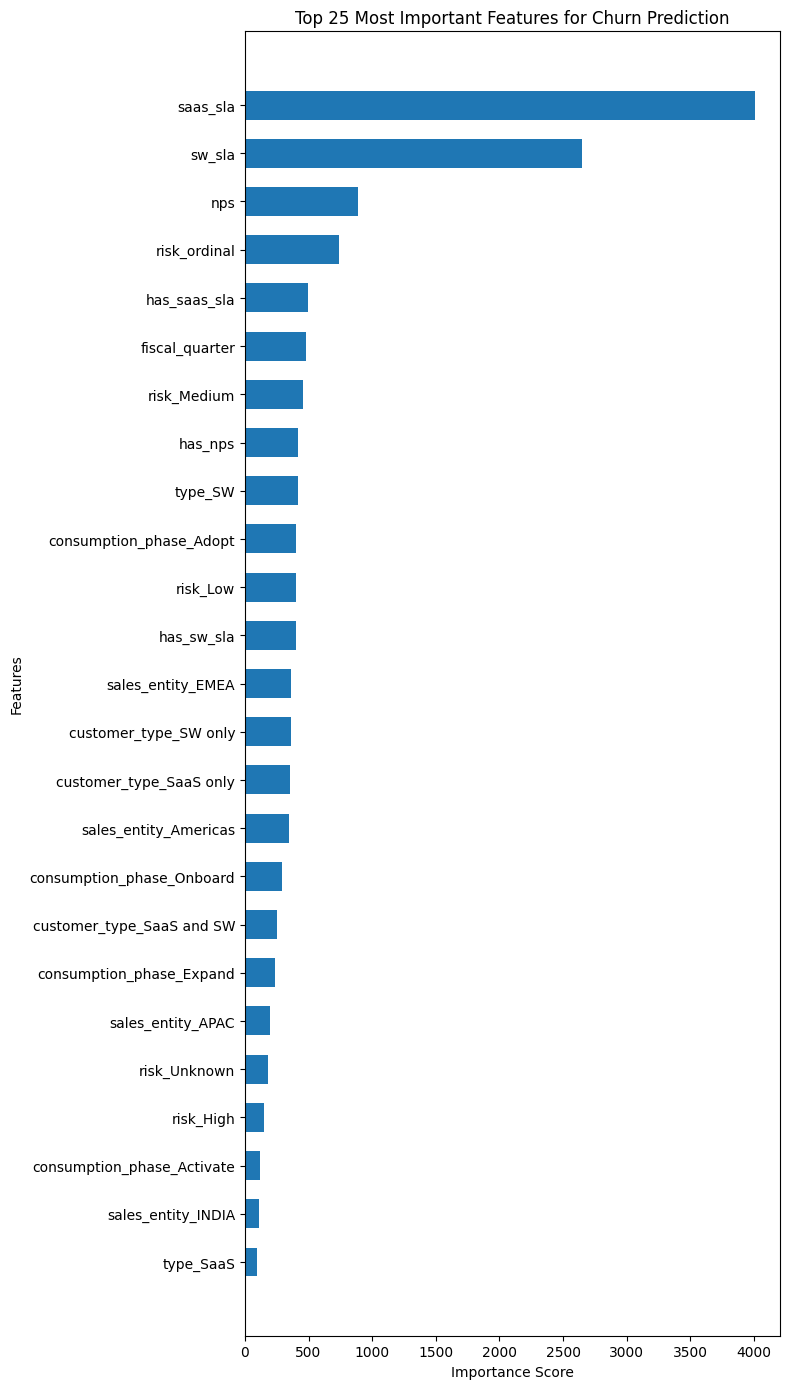

In [23]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importances
importances = lgbm_model.feature_importance()
feature_names = X_train_full.columns

# Sort for better visualization
idx = np.argsort(importances)
sorted_importances = np.array(importances)[idx]
sorted_names = np.array(feature_names)[idx]

plt.figure(figsize=(8, 14))
plt.barh(sorted_names[-25:], sorted_importances[-25:], height=0.6)
plt.title("Top 25 Most Important Features for Churn Prediction")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


Confusion Matrix Heatmap

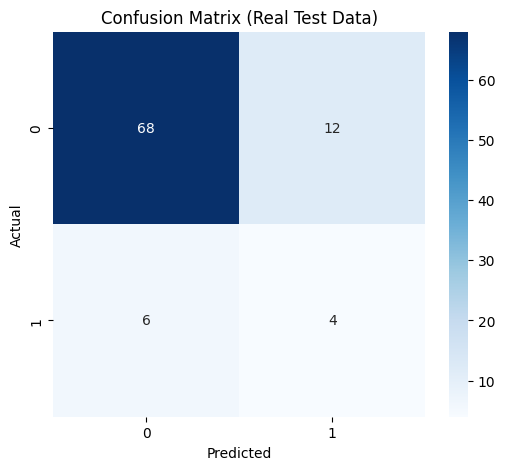

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix (Real Test Data)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


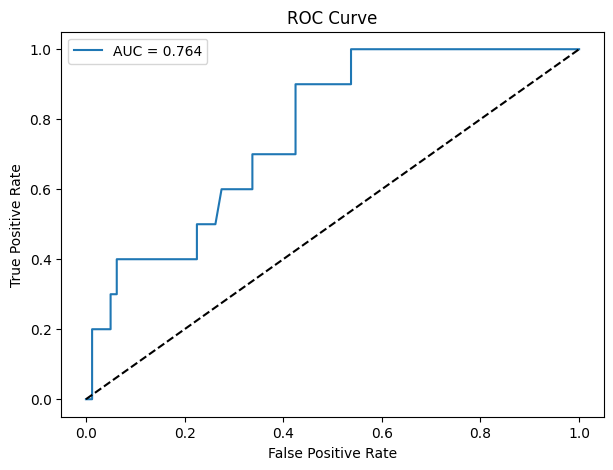

In [25]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


SHAP Summary Plot

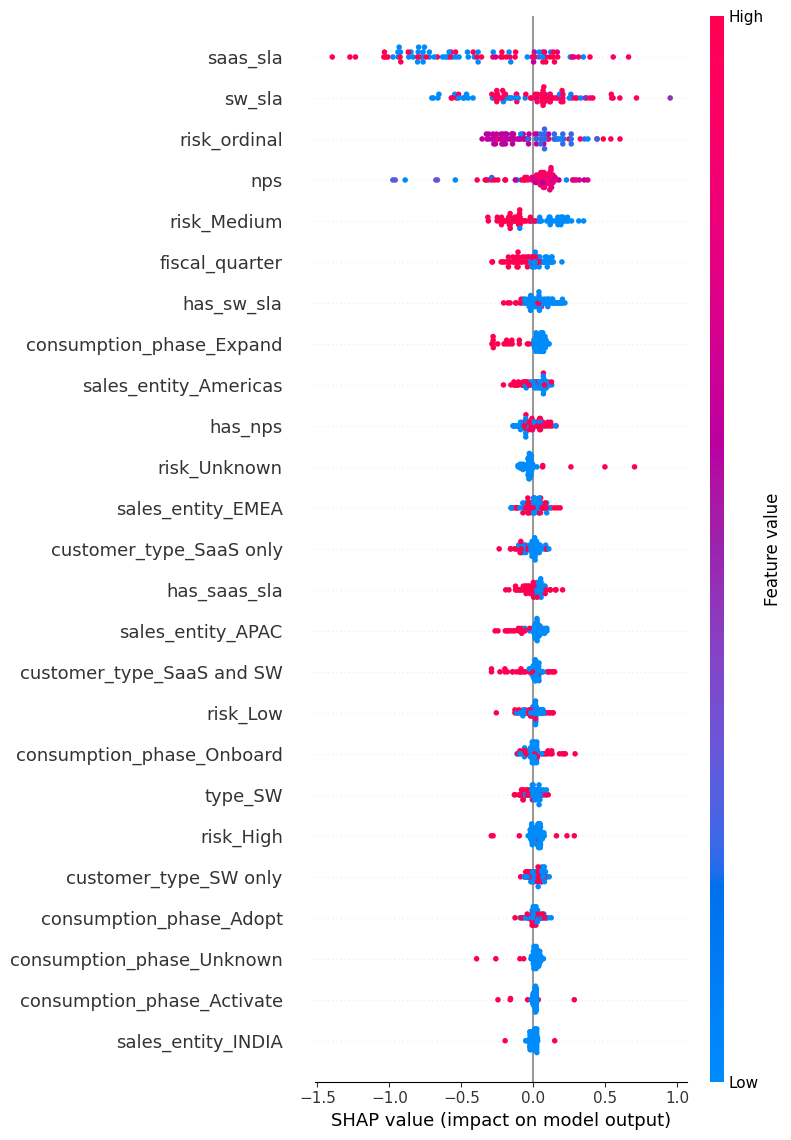

In [28]:
shap.summary_plot(shap_values, X_test, plot_type="dot", max_display=25)
